# Neural Network from Scratch (NumPy)

This notebook is a **portfolio-friendly** rewrite of a practical: it shows how to implement and train a small neural network *without* PyTorch/TensorFlow.

**What it demonstrates**
- Modular layer API (`forward`, `backward`, `gradientStep`)
- Backprop for `Linear`, `ReLU`, `Sigmoid`
- Losses: MSE, L1, Cross-Entropy (stable softmax)
- Training loop (SGD), and a momentum variant
- Basic validation accuracy tracking


In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Make sure we can import from ../src when running from notebooks/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from nn_scratch import MLP, DeepMLP, LinearWithMomentum, ReLU, Sigmoid, MSE, L1, CrossEntropy, train, evaluate

np.random.seed(0)


## Data

If `data/mini_mnist.npz` is present, we use it. Otherwise we fall back to `sklearn.datasets.load_digits` (built-in small handwritten digits).  
Either way, we flatten images into vectors and normalize inputs to `[0, 1]`.


Shapes: (1294, 64) (143, 64) (360, 64)
in_dim: 64 num_classes: 10


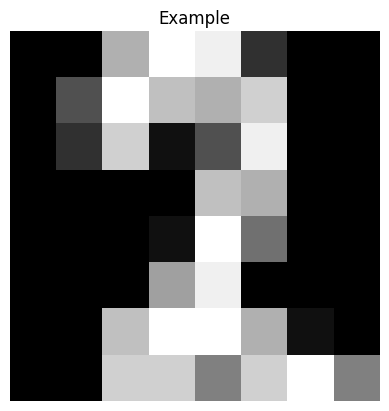

label: 2


In [2]:
from pathlib import Path

data_path = Path("..") / "data" / "mini_mnist.npz"

if data_path.exists():
    data = np.load(data_path)
    X_train = data["train_data"]
    y_train = data["train_labels"]
    X_test = data["test_data"]
    y_test = data["test_labels"]

    # Flatten if needed
    X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
    X_test = X_test.reshape(X_test.shape[0], -1).astype(np.float32)
else:
    from sklearn.datasets import load_digits
    digits = load_digits()
    X = digits.data.astype(np.float32)
    y = digits.target.astype(int)

    # Simple split
    n = X.shape[0]
    idx = np.random.permutation(n)
    split = int(0.8 * n)
    train_idx, test_idx = idx[:split], idx[split:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

# Normalize
X_train /= (X_train.max() + 1e-12)
X_test /= (X_test.max() + 1e-12)

# Validation split
n_val = int(0.1 * len(X_train))
X_val, y_val = X_train[-n_val:], y_train[-n_val:]
X_train, y_train = X_train[:-n_val], y_train[:-n_val]

num_classes = int(np.max(y_train) + 1)
in_dim = X_train.shape[1]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("in_dim:", in_dim, "num_classes:", num_classes)

# Visual sanity check
plt.figure()
plt.title("Example")
side = int(np.sqrt(in_dim))
plt.imshow(X_train[0].reshape(side, side), cmap="gray")
plt.axis("off")
plt.show()
print("label:", y_train[0])


## Train a small MLP (from scratch)

We start with a 1-hidden-layer MLP trained with SGD.


In [3]:
model = MLP(in_dim=in_dim, hidden_dim=128, out_dim=num_classes, non_linearity=ReLU)
loss = CrossEntropy(num_classes=num_classes)

hist = train(
    model=model,
    loss=loss,
    train_data=X_train,
    train_labels=y_train,
    val_data=X_val,
    val_labels=y_val,
    lr=0.05,
    batch_size=64,
    epochs=25,
)

val_loss, val_acc = evaluate(model, loss, X_val, y_val)
test_loss, test_acc = evaluate(model, loss, X_test, y_test)
val_loss, val_acc, test_loss, test_acc


(0.3250510414248238, 0.916083916083916, 0.2376246938526185, 0.9416666666666667)

### Learning curves

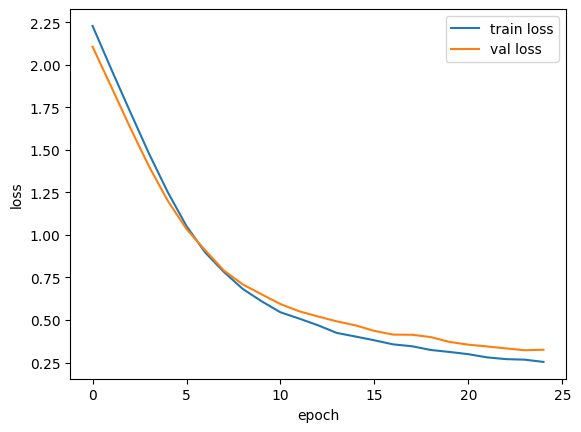

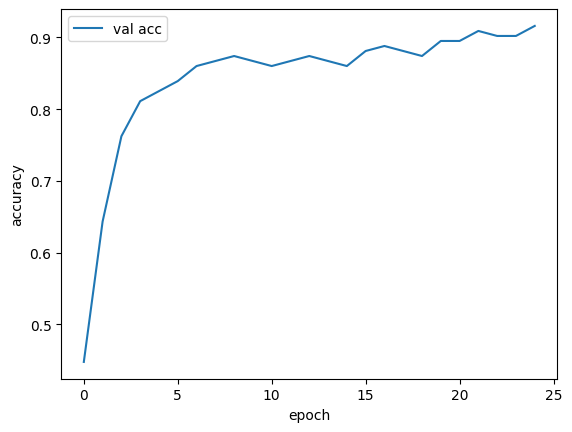

In [4]:
plt.figure()
plt.plot(hist.train_loss, label="train loss")
plt.plot(hist.val_loss, label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
plt.plot(hist.val_acc, label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


## Deeper network + activation experiments

Here’s the same training loop with a deeper MLP and a different non-linearity.


In [5]:
deep = DeepMLP([in_dim, 256, 128, 64, num_classes], non_linearity=ReLU)
loss = CrossEntropy(num_classes=num_classes)

hist_deep = train(deep, loss, X_train, y_train, X_val, y_val, lr=0.05, batch_size=64, epochs=30)

evaluate(deep, loss, X_test, y_test)


(0.11997529769495964, 0.9666666666666667)

## Momentum (optional)

A simple way to stabilize / speed up SGD is momentum. Below we swap the `Linear` layer for `LinearWithMomentum`.


In [6]:
# Momentum version: pass LinearWithMomentum as the linear layer factory
mom_model = MLP(
    in_dim=in_dim,
    hidden_dim=128,
    out_dim=num_classes,
    non_linearity=ReLU,
    linear=lambda a, b: LinearWithMomentum(a, b, momentum=0.9),
)
loss = CrossEntropy(num_classes=num_classes)

hist_mom = train(mom_model, loss, X_train, y_train, X_val, y_val, lr=0.05, batch_size=64, epochs=25)
evaluate(mom_model, loss, X_test, y_test)


(0.0642863296044234, 0.9833333333333333)

## Notes for reviewers

- The core implementation lives in `src/nn_scratch.py` (pure NumPy).
- This notebook is intentionally kept short and “portfolio-first”: it focuses on the *implementation + results*, not course Q/A.
